# 02 — Exploratory Analysis

**Goals**
- **Europe-level overview**
  - Time series plots of HPI across all countries
  - Heatmap of HPI over time (countries × years) with robust scaling
- **Bulgaria vs EU**
  - Line: Bulgaria vs EU **average HPI**
  - Line: Bulgaria vs EU **average net earnings**
- **Outliers**
  - Identify anomalies that can distort visuals and statistics

> Data source: `data/processed/merged_panel.{csv,parquet}` produced in `01_data_preparation.ipynb`.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

PROC = Path("../data/processed")
FIGS = Path("../reports/figures")

PROC, FIGS


(WindowsPath('../data/processed'), WindowsPath('../reports/figures'))

## 1) Load panel

We use the merged panel with columns:
`country, year, house_price_index, net_earnings, unemployment_rate, hicp_index, gdp_per_capita, real_earnings`.


In [45]:
panel = pd.read_csv(PROC / "merged_panel.csv")
panel = panel.sort_values(["country","year"]).reset_index(drop=True)

panel.head()

,country,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings
0,Austria,2015,128.63,34414.48,6.1,100.00,39640.0,34414.480000
1,Austria,2016,136.27,36707.82,6.5,100.97,40690.0,36355.174804
2,Austria,2017,144.48,37220.14,5.9,103.22,41760.0,36059.038946
3,Austria,2018,153.57,37847.53,5.2,105.41,43360.0,35905.065933
4,Austria,2019,162.82,41162.12,4.8,106.98,44570.0,38476.462890


## 2) Europe-level overview — Time series of HPI (all countries)

**Note:** Plotting many lines can be cluttered.  
We draw semi-transparent country lines and overlay **Europe-wide mean** and **median** HPI for context.


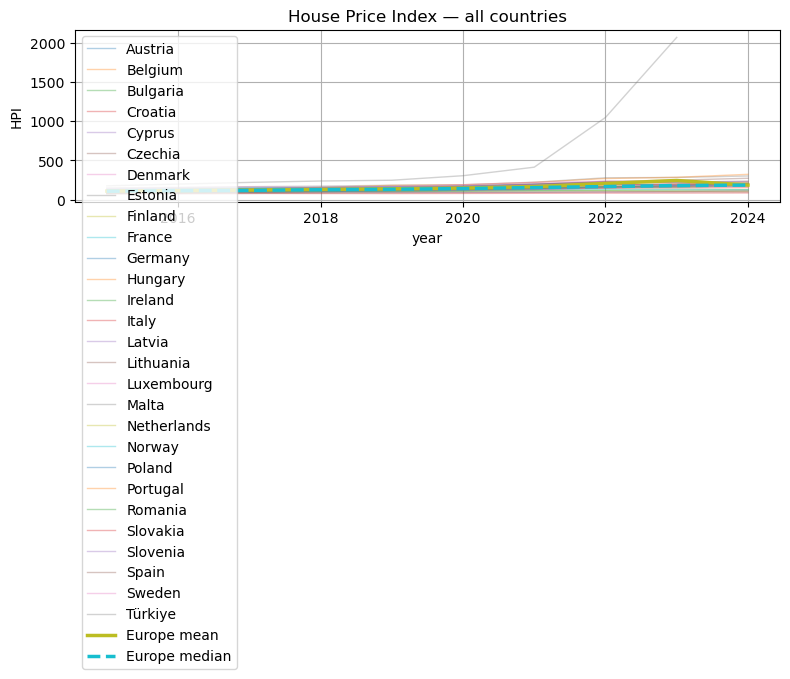

In [46]:
ts = panel.pivot(index="year", columns="country", values="house_price_index")

ax = ts.plot(legend=False, alpha=0.35, linewidth=1)
ax.set_title("House Price Index — all countries")
ax.set_xlabel("Year"); ax.set_ylabel("HPI")

ts_mean = ts.mean(axis=1)
ts_median = ts.median(axis=1)

ts_mean.plot(ax=ax, linewidth=2.5, label="Europe mean")
ts_median.plot(ax=ax, linewidth=2.5, linestyle="--", label="Europe median")
ax.legend()
plt.tight_layout()
plt.savefig(FIGS / "eu_hpi_timeseries_all_countries.png", dpi=140)
plt.show()

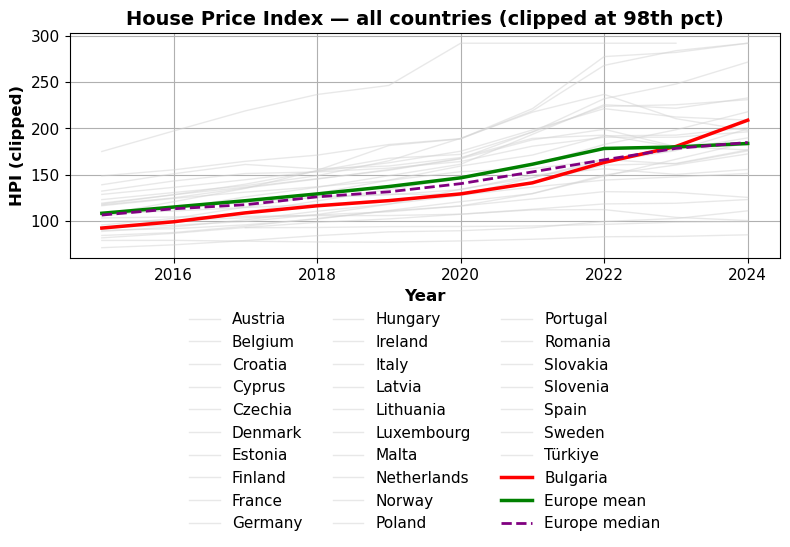

In [47]:
ts = panel.pivot(index="year", columns="country", values="house_price_index")
vmax = np.nanpercentile(ts.values, 98)
ts_clip = ts.clip(upper=vmax)

fig, ax = plt.subplots(figsize=(8,6))

ts_clip.drop(columns=["Bulgaria"], errors="ignore").plot(
    ax=ax, legend=False, alpha=0.5, linewidth=1, color="lightgray"
)

if "Bulgaria" in ts_clip.columns:
    ts_clip["Bulgaria"].plot(ax=ax, color="red", linewidth=2.5, label="Bulgaria")

ts_mean = ts_clip.mean(axis=1)
ts_median = ts_clip.median(axis=1)
ts_mean.plot(ax=ax, linewidth=2.5, color="green", label="Europe mean")
ts_median.plot(ax=ax, linewidth=2.0, linestyle="--", color="purple", label="Europe median")

ax.set_title("House Price Index — all countries (clipped at 98th pct)", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("HPI (clipped)", fontsize=12, fontweight="bold")

ax.tick_params(axis="both", which="major", labelsize=11)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig(FIGS / "eu_hpi_timeseries_clipped_98pct.png", dpi=160, bbox_inches="tight")
plt.show()


## 3) Europe-level overview — HPI heatmap (countries × years)

Large outliers (e.g., Türkiye in recent years) can flatten colors.  
We use **robust color scaling** (2–98th percentile) to keep structure visible.


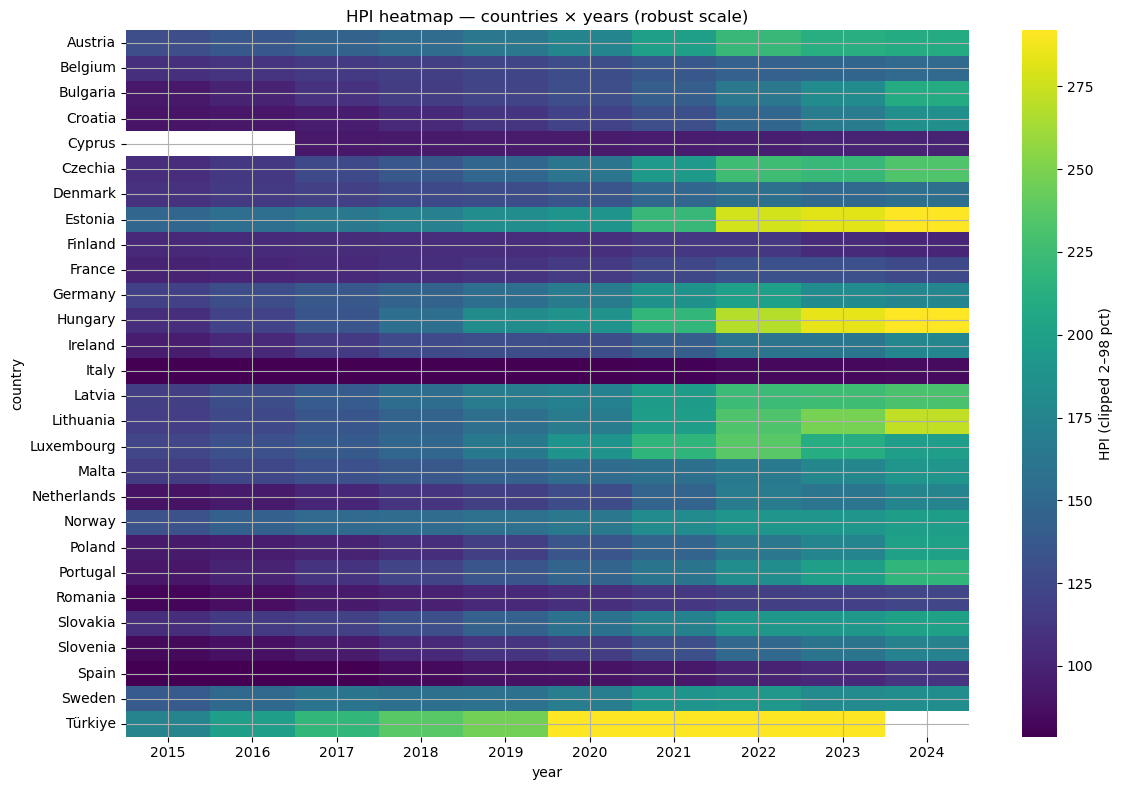

In [48]:
p = panel.pivot(index="country", columns="year", values="house_price_index")

vmin = np.nanpercentile(p.values, 2)
vmax = np.nanpercentile(p.values, 98)

plt.figure(figsize=(12, 8))
sns.heatmap(p, cmap="viridis", vmin=vmin, vmax=vmax, cbar_kws={"label": "HPI (clipped 2–98 pct)"})
plt.title("HPI heatmap — countries × years (robust scale)")
plt.tight_layout()
plt.savefig(FIGS / "eu_hpi_heatmap_robust.png", dpi=140)
plt.show()


## 4) Bulgaria vs EU — define EU27 set

We compute the **EU average** across the EU27 countries present in our panel.
This is a simple unweighted average (mean across countries with data each year),
not the official Eurostat aggregate.

In [54]:
EU27 = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia","Finland",
    "France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg",
    "Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"
}

panel_eu = panel[panel["country"].isin(EU27)].copy()

eu_hpi = (
    panel_eu.groupby("year")["house_price_index"]
    .mean()
    .rename("eu_hpi_mean")
    .reset_index()
)

eu_earn = (
    panel_eu.groupby("year")["net_earnings"]
    .mean()
    .rename("eu_earn_mean")
    .reset_index()
)

eu_hpi.head(10), eu_earn.head(10)


(   year  eu_hpi_mean
 0  2015   104.632800
 1  2016   110.595600
 2  2017   116.968462
 3  2018   124.116923
 4  2019   132.187692
 5  2020   140.283846
 6  2021   155.487692
 7  2022   173.445000
 8  2023   175.199615
 9  2024   184.623846,
    year  eu_earn_mean
 0  2015  22452.376800
 1  2016  23045.968800
 2  2017  23534.203846
 3  2018  24230.544231
 4  2019  25174.882692
 5  2020  25869.896154
 6  2021  26682.798462
 7  2022  28255.733462
 8  2023  30123.759615
 9  2024  31681.240000)

## 5) Bulgaria vs EU — HPI

We plot Bulgaria’s HPI against the **EU average (mean across EU27 countries)**.


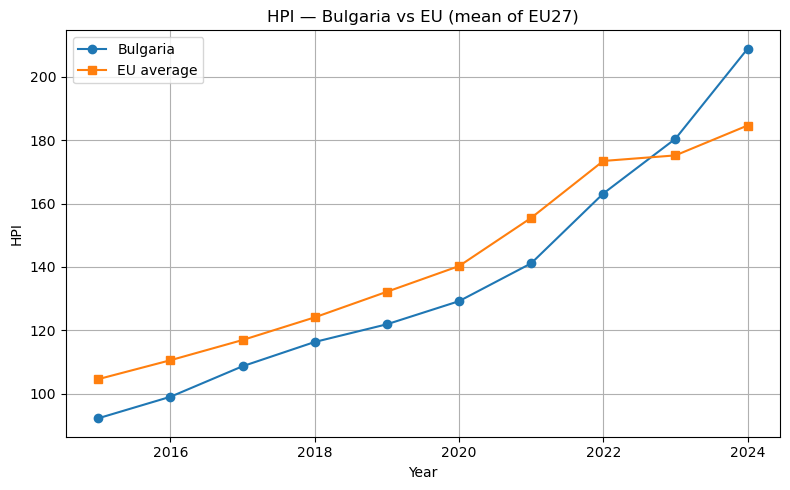

,year,bg_hpi,eu_hpi_mean
0,2015,92.29,104.632800
1,2016,99.07,110.595600
2,2017,108.70,116.968462
3,2018,116.35,124.116923
4,2019,121.93,132.187692
5,2020,129.22,140.283846
6,2021,141.15,155.487692
7,2022,163.17,173.445000
8,2023,180.44,175.199615
9,2024,208.82,184.623846


In [50]:
bg = panel[panel["country"] == "Bulgaria"][["year","house_price_index"]].rename(
    columns={"house_price_index":"bg_hpi"}
)
plot_hpi = bg.merge(eu_hpi, on="year", how="inner").sort_values("year")

plt.figure()
plt.plot(plot_hpi["year"], plot_hpi["bg_hpi"], marker="o", label="Bulgaria")
plt.plot(plot_hpi["year"], plot_hpi["eu_hpi_mean"], marker="s", label="EU average")
plt.title("HPI — Bulgaria vs EU (mean of EU27)")
plt.xlabel("Year"); plt.ylabel("HPI")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "bg_vs_eu_hpi.png", dpi=140)
plt.show()

plot_hpi

## 6) Bulgaria vs EU — Net Earnings

Now compare **net earnings** for Bulgaria vs the EU average.

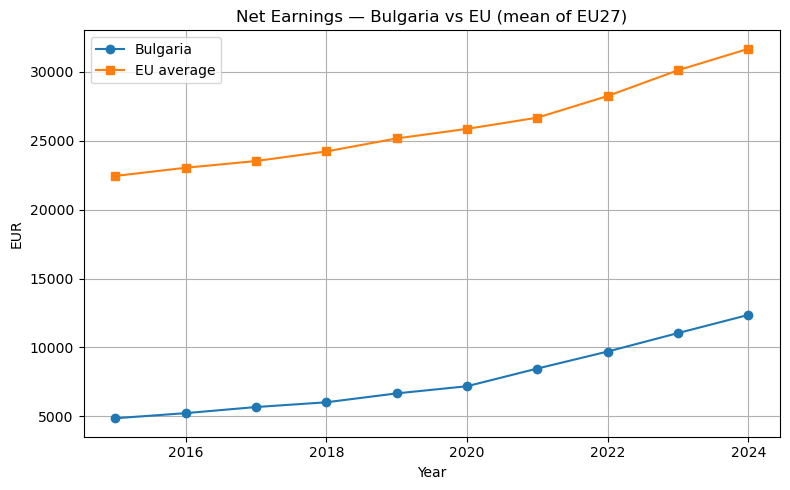

,year,bg_net_earnings,eu_earn_mean
0,2015,4860.67,22452.376800
1,2016,5231.03,23045.968800
2,2017,5674.72,23534.203846
3,2018,6019.75,24230.544231
4,2019,6665.67,25174.882692
5,2020,7185.43,25869.896154
6,2021,8469.05,26682.798462
7,2022,9704.27,28255.733462
8,2023,11043.88,30123.759615
9,2024,12362.37,31681.240000


In [51]:
bg_e = panel[panel["country"] == "Bulgaria"][["year","net_earnings"]].rename(
    columns={"net_earnings":"bg_net_earnings"}
)
plot_earn = bg_e.merge(eu_earn, on="year", how="inner").sort_values("year")

plt.figure()
plt.plot(plot_earn["year"], plot_earn["bg_net_earnings"], marker="o", label="Bulgaria")
plt.plot(plot_earn["year"], plot_earn["eu_earn_mean"], marker="s", label="EU average")
plt.title("Net Earnings — Bulgaria vs EU (mean of EU27)")
plt.xlabel("Year"); plt.ylabel("EUR")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "bg_vs_eu_net_earnings.png", dpi=140)
plt.show()

plot_earn

## 7) Identify anomalies / outliers

We flag **high HPI** and **high HICP (inflation)** values using percentile cutoffs,
and list the **top 10** rows. This helps explain visual scaling issues.


In [52]:
hpi_p99  = panel["house_price_index"].quantile(0.99)
hicp_p99 = panel["hicp_index"].quantile(0.99)

out_hpi  = (panel[panel["house_price_index"] >= hpi_p99]
            .sort_values("house_price_index", ascending=False)
            [["country","year","house_price_index","net_earnings","hicp_index"]]
            .head(10))

out_hicp = (panel[panel["hicp_index"] >= hicp_p99]
            .sort_values("hicp_index", ascending=False)
            [["country","year","hicp_index","house_price_index","net_earnings"]]
            .head(10))

hpi_p99, hicp_p99, out_hpi, out_hicp


(np.float64(343.4456000000008),
 np.float64(188.4424000000003),
      country  year  house_price_index  net_earnings  hicp_index
 276  Türkiye  2023            2066.46       8768.30      570.94
 275  Türkiye  2022            1046.23       6285.77      370.82
 274  Türkiye  2021             412.75       5998.90      215.24,
      country  year  hicp_index  house_price_index  net_earnings
 276  Türkiye  2023      570.94            2066.46       8768.30
 275  Türkiye  2022      370.82            1046.23       6285.77
 274  Türkiye  2021      215.24             412.75       5998.90)

## 8) Cleaner heatmap variants

- **standardize per country**: show relative highs/lows against its own average.

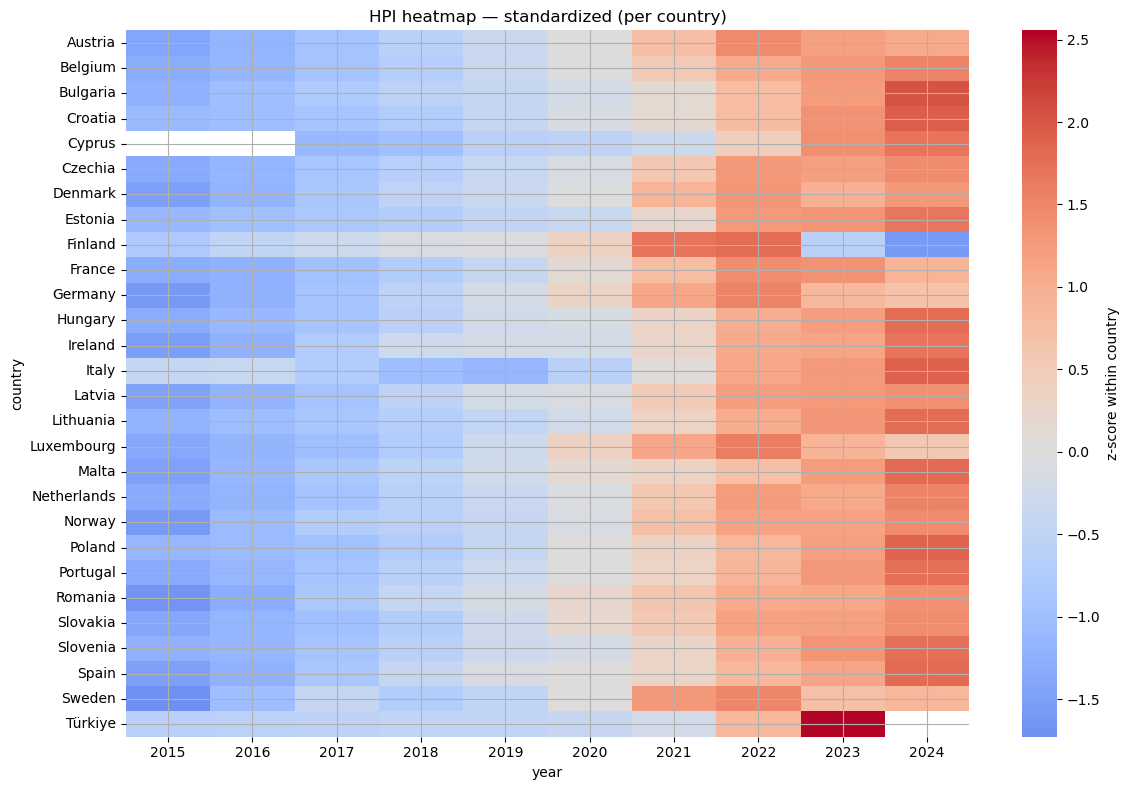

In [53]:
p_z = p.apply(lambda s: (s - s.mean()) / s.std(ddof=0), axis=1)
plt.figure(figsize=(12, 8))
sns.heatmap(p_z, cmap="coolwarm", center=0, cbar_kws={"label":"z-score within country"})
plt.title("HPI heatmap — standardized (per country)")
plt.tight_layout()
plt.savefig(FIGS / "eu_hpi_heatmap_zscore.png", dpi=140)
plt.show()


# Exploratory Analysis — Notes for the report

**Europe-wide trends:**
- From 2015 to 2024, **EU average HPI increased ~76%**, while **EU average net earnings grew ~41%**.  
- This mismatch suggests worsening affordability in Europe overall.

**Bulgaria vs EU:**
- Bulgaria’s HPI nearly **doubled (+127%)** from 2015–2024.
- Net earnings in Bulgaria grew even faster (**+155%**) — far above the EU average.  
- Until 2022, Bulgaria’s HPI was below the EU mean, but by **2023–2024 it overtook the EU average**, showing a recent acceleration.
- Overall, Bulgaria’s affordability (earnings vs HPI) improved relative to Europe, although high growth raises questions about sustainability.

**Outliers:**
- Türkiye: extremely high HPI and inflation (HICP), dominating heatmaps and skewing averages.  
- Luxembourg: extreme earnings and GDP levels, outlier at the high-income end.  

**Figures saved:**
- `reports/figures/eu_hpi_timeseries_all_countries.png`  
- `reports/figures/eu_hpi_timeseries_clipped_98pct.png`  
- `reports/figures/eu_hpi_heatmap_robust.png`  
- `reports/figures/eu_hpi_heatmap_zscore.png`  
- `reports/figures/bg_vs_eu_hpi.png`  
- `reports/figures/bg_vs_eu_net_earnings.png`


